# **Online Advertising Click Through Rate (CTR) Prediction**

Accurate Click Through Rate (CTR) prediction plays a very important role in ranking the candidate ads and then affects the ads performance in sponsored search and real-time bidding systems.
In this project, I analyzed a mobile ad dataset (based on [Kaggle](https://www.kaggle.com/c/avazu-ctr-prediction)) and implemented multiple machine learning models to predict whether a mobile ad will be clicked.

# **Part 1: Data Loading and Preprocessing**

## 1.1 Data Loading

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

# pandas display settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
# mount google drive
drive.mount('/content/ggdrive')
fpath = '/content/ggdrive/MyDrive/dataSet/CTR_avazu/'
random.seed(42)

Mounted at /content/ggdrive


In [ ]:
# load data

# date parse lambda function 
parse_date = lambda val: datetime.strptime(val, '%y%m%d%H')

# data_load function
def data_load(fnm, p=-1, nrows=None, parse_date=parse_date):
  '''
  fnm: string, name of file
  p: subsampling probability
  '''
  df = pd.read_csv(fpath + fnm, compression='gzip',
                   parse_dates=['hour'], date_parser=parse_date,
                   skiprows=lambda i: i>0 and random.random() > p)
  df['day_hour'] = df['hour']
  df['date'] = df['hour'].dt.date
  df['weekday'] = df['hour'].dt.dayofweek  #day_name()
  df['hour'] = df['hour'].dt.hour
  return df

# training data
df_train = data_load('train.gz', p=0.03)
#df_test = data_load('test.gz', p=-0.5)

In [ ]:
df_train.sample(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day_hour,date,weekday
985817,6866970590507777964,0,3,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,480f83f0,8a4875bd,1,0,21893,320,50,2526,0,167,100079,221,2014-10-29 03:00:00,2014-10-29,2
473775,6404561339380090354,1,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,eb23ac18,8a4875bd,1,0,21674,320,50,2495,2,167,100173,23,2014-10-24 15:00:00,2014-10-24,4
501493,11185768791091823524,1,1,1005,1,4c391571,5a3b8f37,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,33c9463a,2203a096,1,0,15702,320,50,1722,0,35,100084,79,2014-10-25 01:00:00,2014-10-25,5
1050149,14147580384647716793,0,15,1002,0,d70360ea,39b3d1ff,50e219e0,ecad2386,7801e8d9,07d7df22,a19595da,5873ef24,911a3c09,0,0,23438,320,50,2684,2,1327,-1,52,2014-10-29 15:00:00,2014-10-29,2
992068,10522928838831730249,0,5,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a4ea4bbf,8a4875bd,1,0,23168,320,50,2668,0,35,100084,221,2014-10-29 05:00:00,2014-10-29,2


## 1.2 Exploratory Data Analysis

### 1.2.1 Statistical information

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211439 entries, 0 to 1211438
Data columns (total 27 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   id                1211439 non-null  uint64        
 1   click             1211439 non-null  int64         
 2   hour              1211439 non-null  int64         
 3   C1                1211439 non-null  int64         
 4   banner_pos        1211439 non-null  int64         
 5   site_id           1211439 non-null  object        
 6   site_domain       1211439 non-null  object        
 7   site_category     1211439 non-null  object        
 8   app_id            1211439 non-null  object        
 9   app_domain        1211439 non-null  object        
 10  app_category      1211439 non-null  object        
 11  device_id         1211439 non-null  object        
 12  device_ip         1211439 non-null  object        
 13  device_model      1211439 non-null  object

From the info table, we can find all feature are categorical features

categorical = ['date', 'weekday', 'hour', 'C1', 'C14', 'C15', 'C16',
               'C17', 'C18', 'C19', 'C20', 'C21', 'banner_pos',
               'site_id', 'site_domain', 'site_category',
               'app_id', 'app_domain', 'app_category', 'device_id',
               'device_ip', 'device_model', 'device_type', 'device_conn_type']

In [ ]:
df_train.nunique()

id                  1211439
click                     2
hour                     24
C1                        7
banner_pos                7
site_id                2793
site_domain            3074
site_category            21
app_id                 3290
app_domain              202
app_category             27
device_id            178820
device_ip            647484
device_model           5332
device_type               5
device_conn_type          4
C14                    2302
C15                       8
C16                       9
C17                     425
C18                       4
C19                      67
C20                     165
C21                      60
day_hour                240
date                     10
weekday                   7
dtype: int64

"id" has 2020327 unique values.

In [ ]:
df_train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
day_hour            0
date                0
weekday             0
dtype: int64

In [ ]:
df_train.astype('object').describe()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day_hour,date,weekday
count,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439
unique,1211439,2,24,7,7,2793,3074,21,3290,202,27,178820,647484,5332,5,4,2302,8,9,425,4,67,165,60,240,10,7
top,1813785350290567224,0,13,1005,0,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,a99f214a,6b9769f2,8a4875bd,1,0,4687,320,50,1722,0,35,-1,23,2014-10-22 09:00:00,2014-10-22,1
freq,1,1005619,71966,1113140,872441,437292,453441,495460,774147,816053,784179,999894,6151,73766,1117984,1045434,28362,1129748,1142340,134643,506953,364411,566358,266332,13578,159765,281705


From the table we can find in "C20" feature, the most frequent value is -1 (freq of 946240). It looks like it's missing value. But we don't know the feature detail.

### 1.2.2 Visualization of target variable

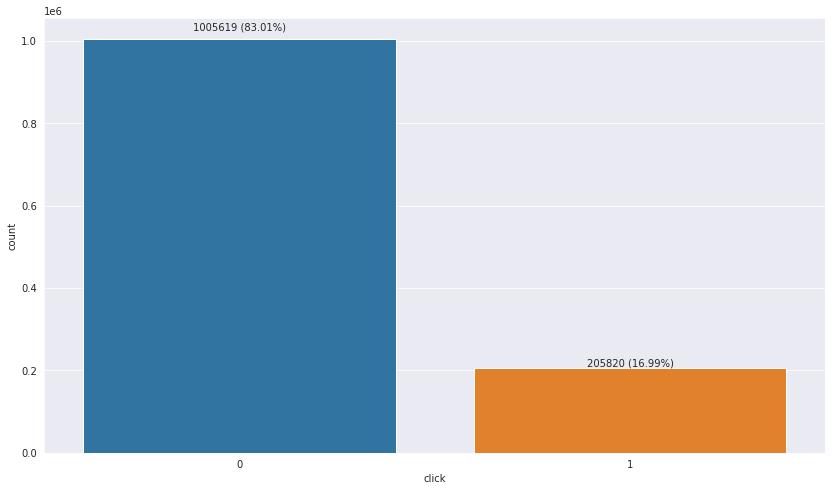

In [ ]:
fig = plt.figure(figsize=[14, 8])
ax = sns.countplot(x="click", data=df_train)
for p in ax.patches:
  hgt = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2.,
          hgt * 1.02,
          f"{hgt} ({hgt/df_train.shape[0]*100:.2f}%)",
          ha="center")

The overall click through rate is approximate 17%.

### 1.2.3 The time distribution of the clicked ads

In [ ]:
df_train.day_hour.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 1211439
unique                    240
top       2014-10-22 09:00:00
freq                    13578
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: day_hour, dtype: object

The data covers 10 days of click stream data (from 2014-10-21 00:00:00 to 2014-10-30 23:00:00, total 240 hours).

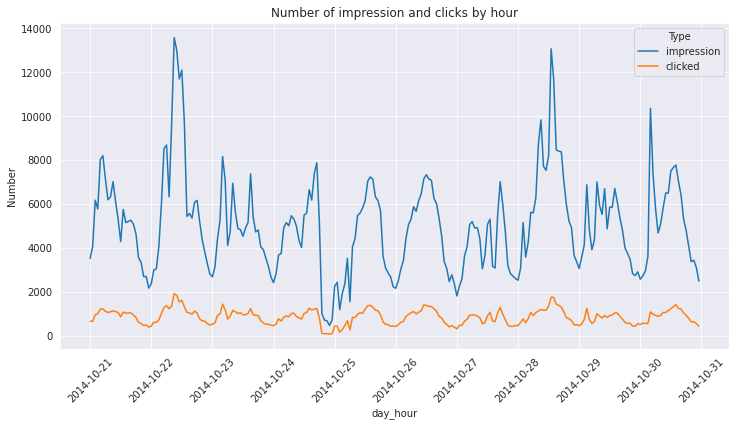

,impression,clicked
impression,1.000,0.944
clicked,0.944,1.000


In [ ]:
df1 = df_train.groupby('day_hour').agg({'click': ['count', 'sum']}).reset_index()
df1.columns = ['day_hour', 'impression', 'clicked']
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.lineplot(x='day_hour', y='Number', hue='Type', \
             data=pd.melt(df1, ['day_hour'], value_name="Number", var_name="Type"))
plt.xticks(rotation=45)
plt.title('Number of impression and clicks by hour')

#df1['ctr'] = df1['clicked']/df1['impression'] * 100
#ax2 = ax.twinx()
#ax2.grid(False)
#ax2.plot(df1.day_hour, df1.ctr, 'r-')
#ax2.set_ylabel("Mean Click Through Rate", color='red')
#ax2.set_ylim([0, math.ceil(ax2.get_ylim()[1]/5.0)*5.0])

plt.show()

df1[['impression', 'clicked']].corr()

The hourly clicked ads numbers are strong correlated with the hourly explored ads numbers. The hourly clicks pattern looks pretty similar every day.

### 1.2.4 A general function for analyze other features

In [ ]:
import math

def categClassify(x, hue=None, data=None, value_stat=None, figSZ=[12, 6], \
                  nloc=False, lblFunc=False, rotate=False, topN=False):

  # statistical table
  stat = pd.pivot_table(data, index=[x], columns=[hue],
               values=value_stat, aggfunc=lambda x: len(x),
               fill_value=0)
  stat['CTR'] = stat[1]/stat.sum(axis=1) * 100
  tot = data.shape[0]
  stat['percentOfData'] = stat.sum(axis=1) / tot
  if topN:
    stat.sort_values(by='percentOfData', ascending=False, inplace=True)
    stat = stat[0:topN]
    data = data[data[x].isin(list(stat.index))]
  print(stat)

  # visualization
  fig, ax = plt.subplots(figsize=figSZ)
  ax = sns.countplot(x=x, hue=hue, data=data, order=stat.index)
  if nloc:
    ax.xaxis.set_major_locator(plt.MaxNLocator(nloc))
  if lblFunc:
    lbls = [lblFunc(lbl) for lbl in ax.get_xticklabels()]
    _ = ax.set_xticklabels(lbls)
  if rotate:
    lbls = ax.get_xticklabels()
    _ = ax.set_xticklabels(lbls, rotation=rotate)
  ax.set_title("Number of examples for {} over {}".format(hue, x))
  ax.legend(title=hue, loc='upper right')

  # also show the CTR over each feature
  if 1 == 1:
    ax2 = ax.twinx()
    ax2.grid(False)
    #ax2.plot(stat.index, stat.ctr, 'r--o')
    #print(stat.index.get_level_values(0))
    #ax2.plot(stat.index.get_level_values(0), stat.ctr, 'r--o')
    ax2.plot(range(stat.index.shape[0]), stat.CTR, 'r--o')
    ax2.set_ylabel("Mean Click Through Rate", color='red')
    ax2.set_ylim([0, math.ceil(ax2.get_ylim()[1]/5.0)*5.0])

#### **Context features**

##### **Hourly distribution**

click      0      1    CTR  percentOfData
hour                                     
0      20709   4613 18.217          0.021
1      24092   5451 18.451          0.024
2      29798   6513 17.937          0.030
3      34569   7305 17.445          0.035
4      48216   9161 15.966          0.047
5      49772   9725 16.345          0.049
6      43919   8778 16.657          0.044
7      45536   9960 17.947          0.046
8      52734  10224 16.239          0.052
9      57550  10909 15.935          0.057
10     53744  10570 16.435          0.053
11     50787  10518 17.157          0.051
12     55097  11363 17.098          0.055
13     59810  12156 16.891          0.059
14     54107  11889 18.015          0.054
15     50985  11314 18.161          0.051
16     50475  10929 17.799          0.051
17     50161  10586 17.426          0.050
18     43923   8890 16.833          0.044
19     33065   6267 15.934          0.032
20     28384   5348 15.854          0.028
21     25228   4784 15.940        

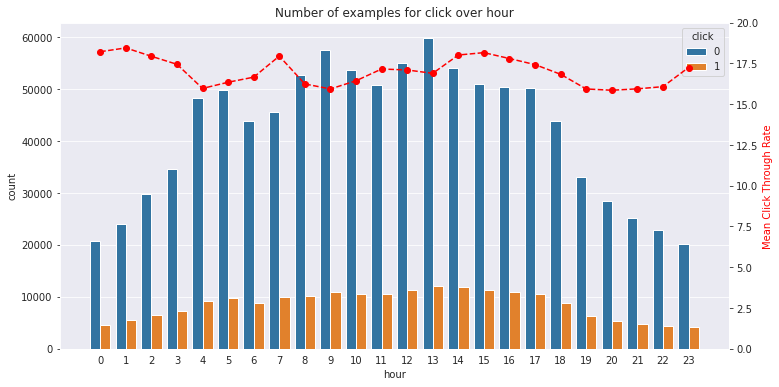

In [ ]:
categClassify(x='hour', hue='click', data=df_train, value_stat='id')

We can find here the highest number of clicks is about 13:00pm and 14:00 pm, and the lowest number of clicks is about midnight.

On the other hand, the highest mean CTR is about midnight and 7:00 am and 15:00 pm. It's interesting.

##### **weekly distribution**

click         0      1    CTR  percentOfData
weekday                                     
0         79320  17345 17.943          0.080
1        236188  45517 16.158          0.233
2        231760  43065 15.670          0.227
3        200143  42817 17.623          0.201
4         82098  17603 17.656          0.082
5         82349  18339 18.214          0.083
6         93761  21134 18.394          0.095


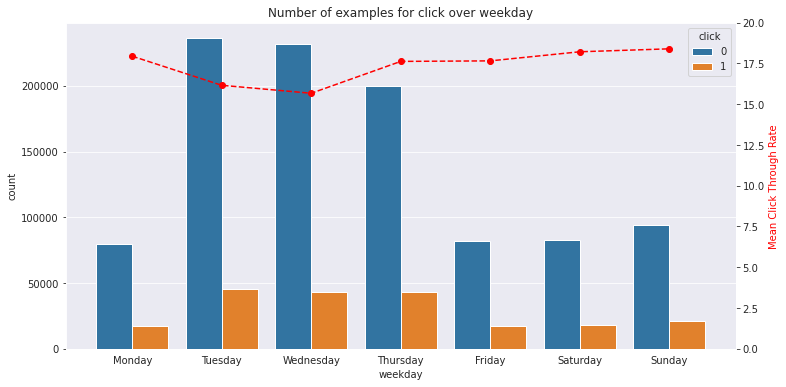

In [ ]:
weekdayname = {'0': 'Monday', '1': 'Tuesday', '2': 'Wednesday', '3': 'Thursday',
               '4': 'Friday', '5': 'Saturday', '6': 'Sunday'}
def weekdayLabel(lbl):
  lbl = weekdayname[lbl.get_text()]
  return lbl

categClassify(x='weekday', hue='click', data=df_train, value_stat='id', lblFunc=weekdayLabel)

We can find here middle of week (Tuesday, Wednesday, and Thursday) have the highest number of impressions and clicks, but weekend (Saturday and Sunday) have the highest CTR.

##### **Banner position**

click            0       1    CTR  percentOfData
banner_pos                                      
0           728850  143591 16.459          0.720
1           275178   61690 18.313          0.278
2              352      51 12.655          0.000
3               54       6 10.000          0.000
4              168      63 27.273          0.000
5              128      25 16.340          0.000
7              889     394 30.709          0.001


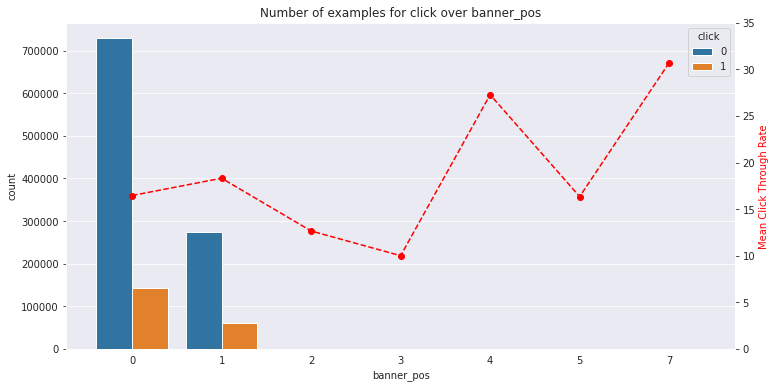

In [ ]:
categClassify(x='banner_pos', hue='click', data=df_train, value_stat="id")

Banner position 0 and 1 have the highest number of impressions and clicks, however, banner position 7 has the highest CTR. Increasing the number of ads placed on banner position 7 seems to be a good idea.

#### **Site features**

In [ ]:
df_train[['site_id', 'site_domain', 'site_category']].describe()

,site_id,site_domain,site_category
count,1211439,1211439,1211439
unique,2793,3074,21
top,85f751fd,c4e18dd6,50e219e0
freq,437292,453441,495460


##### **site_id**

click          0      1    CTR  percentOfData
site_id                                      
85f751fd  385020  52272 11.954          0.361
1fbe01fe  153821  40156 20.701          0.160
e151e245   55723  23346 29.526          0.065
d9750ee7   20649   8109 28.197          0.024
5b08c53b   14605  12726 46.563          0.023
5b4d2eda   20160   2936 12.712          0.019
856e6d3f   22016    969  4.216          0.019
a7853007   12328   1424 10.355          0.011
b7e9786d   10305    797  7.179          0.009
5ee41ff2    7000   3401 32.699          0.009


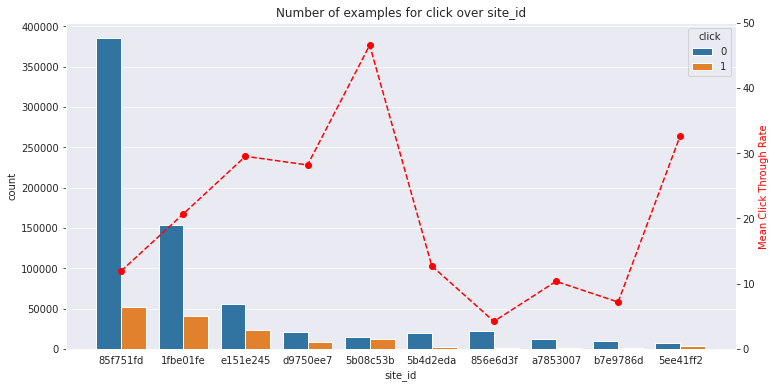

In [ ]:
categClassify(x='site_id', hue='click', data=df_train, value_stat="id", topN=10)

The CTR for the top 10 site_id have big fluctuations (4.23% ~ 46.41%).

##### **site_domain**

click             0      1    CTR  percentOfData
site_domain                                     
c4e18dd6     397634  55807 12.307          0.374
f3845767     153821  40156 20.701          0.160
7e091613      73910  25666 25.775          0.082
7687a86e      20840  17784 46.044          0.032
98572c79      21543   8194 27.555          0.025
16a36ef3      22111   3569 13.898          0.021
58a89a43      22016    969  4.216          0.019
9d54950b       9995   1330 11.744          0.009
b12b9f85      10398    810  7.227          0.009
17d996e6       7124   3423 32.455          0.009


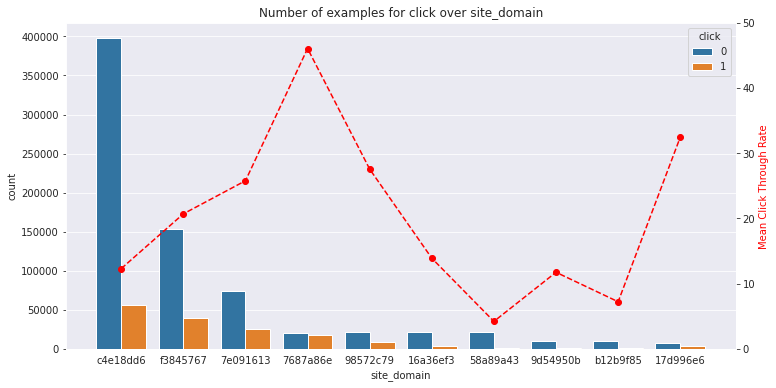

In [ ]:
categClassify(x='site_domain', hue='click', data=df_train, value_stat="id", topN=10)

Similar to site_id, the CTR for the top 10 site_domain also have big fluctuations (4.23% ~ 45.79%).

##### **site_category**

click               0      1    CTR  percentOfData
site_category                                     
50e219e0       431704  63756 12.868          0.409
f028772b       311386  68011 17.926          0.313
28905ebd       174510  46158 20.917          0.182
3e814130        65673  25845 28.240          0.076
f66779e6         7138    297  3.995          0.006
75fa27f6         4349    542 11.082          0.004
335d28a8         3768    416  9.943          0.003
76b2941d         3092     98  3.072          0.003
c0dd3be3         1146    139 10.817          0.001
72722551          821     41  4.756          0.001


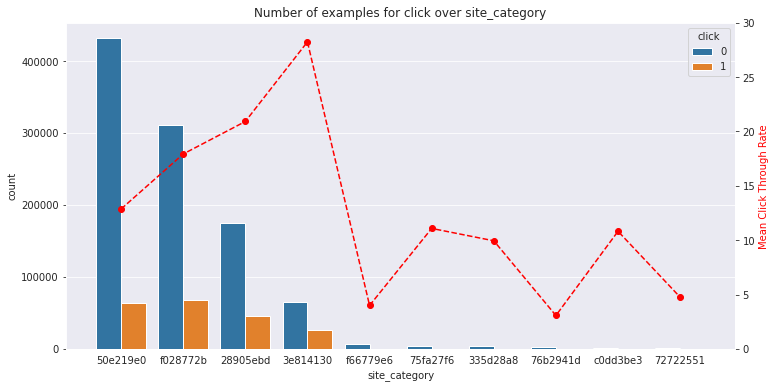

In [ ]:
categClassify(x='site_category', hue='click', data=df_train, value_stat="id", topN=10)

The CTR for the top 10 site_category have big fluctuations (2.95% ~ 28.15%).

#### **App features**

In [ ]:
df_train[['app_id', 'app_domain', 'app_category']].describe()

,app_id,app_domain,app_category
count,1211439,1211439,1211439
unique,3290,202,27
top,ecad2386,7801e8d9,07d7df22
freq,774147,816053,784179


##### **app_id**

click          0       1    CTR  percentOfData
app_id                                        
ecad2386  620599  153548 19.834          0.639
92f5800b   45786     902  1.932          0.039
e2fcccd2   27096    6670 19.754          0.028
febd1138   21640    1106  4.862          0.019
9c13b419   15749    6970 30.679          0.019
7358e05e   14663    3486 19.208          0.015
a5184c22   11136    3614 24.502          0.012
d36838b1   12694     930  6.826          0.011
685d1c4c   11313     870  7.141          0.010
54c5d545   10135    1522 13.057          0.010


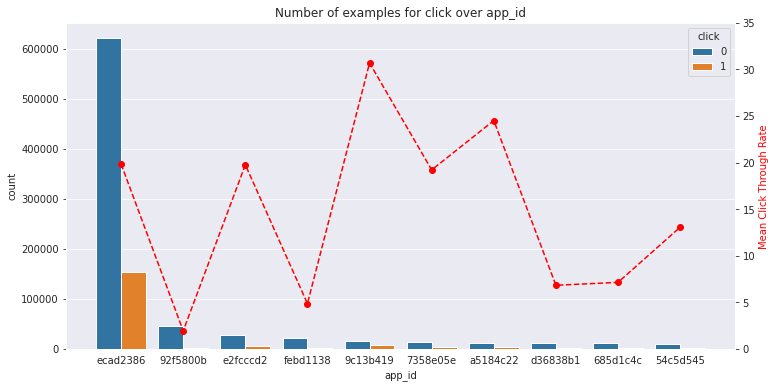

In [ ]:
categClassify(x='app_id', hue='click', data=df_train, value_stat="id", topN=10)

The CTR for the top 10 app_id have big fluctuations (1.91% ~ 30.54%).

##### **app_domain**

click            0       1    CTR  percentOfData
app_domain                                      
7801e8d9    657211  158842 19.465          0.674
2347f47a    135443   21861 13.897          0.130
ae637522     55082    1388  2.458          0.047
5c5a694b     27103    6670 19.750          0.028
82e27996     21641    1106  4.862          0.019
d9b5648e     19220    2410 11.142          0.018
0e8616ad     18317    1363  6.926          0.016
b9528b13     15492    3533 18.570          0.016
b8d325c3     12360    3691 22.995          0.013
aefc06bd      8295     621  6.965          0.007


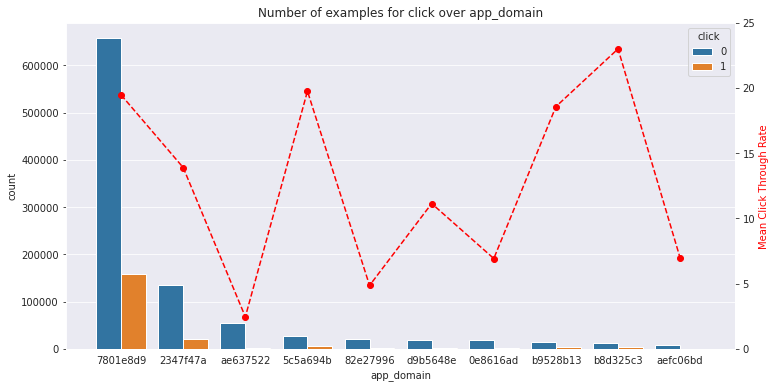

In [ ]:
categClassify(x='app_domain', hue='click', data=df_train, value_stat="id", topN=10)

The CTR for the top 10 app_domain have big fluctuations (2.40% ~ 23.11%).

##### **app_category**

click              0       1    CTR  percentOfData
app_category                                      
07d7df22      628240  155939 19.886          0.647
0f2161f8      255243   31140 10.874          0.236
cef3e649       46670    4897  9.496          0.043
8ded1f7a       40195    3971  8.991          0.036
f95efa07       25869    8529 24.795          0.028
d1327cf5        3216     498 13.409          0.003
09481d60        1414     264 15.733          0.001
dc97ec06        1348     241 15.167          0.001
75d80bbe        1069      98  8.398          0.001
fc6fa53d         651      35  5.102          0.001


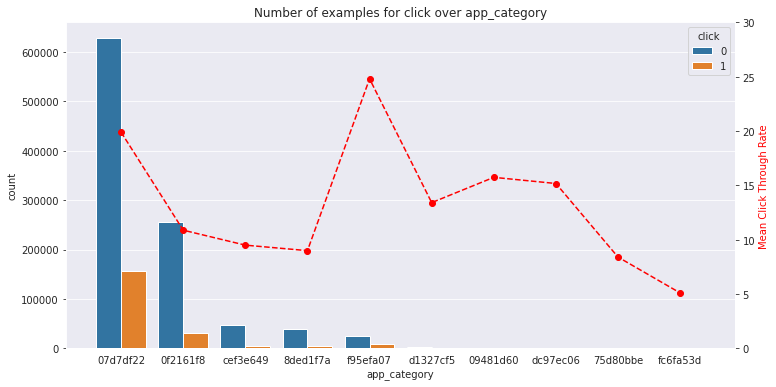

In [ ]:
categClassify(x='app_category', hue='click', data=df_train, value_stat="id", topN=10)

The CTR for the top 10 site_category have big fluctuations (2.95% ~ 28.15%).

#### **Device features**

In [ ]:
df_train[['device_id', 'device_ip', 'device_model',\
          'device_type', 'device_conn_type']].astype('object').describe()

,device_id,device_ip,device_model,device_type,device_conn_type
count,1211439,1211439,1211439,1211439,1211439
unique,178820,647484,5332,5,4
top,a99f214a,6b9769f2,8a4875bd,1,0
freq,999894,6151,73766,1117984,1045434


##### **device_id**

click           0       1    CTR  percentOfData
device_id                                      
a99f214a   825737  174157 17.418          0.825
0f7c61dc      157     474 75.119          0.001
c357dbff      215     357 62.413          0.001
936e92fb      368      28  7.071          0.000
afeffc18      226      76 25.166          0.000
3cdb4052       19      73 79.348          0.000
cef4c8cc       94      32 25.397          0.000
b09da1c4      100      19 15.966          0.000
d857ffbb       79      23 22.549          0.000
987552d1      122       0  0.000          0.000


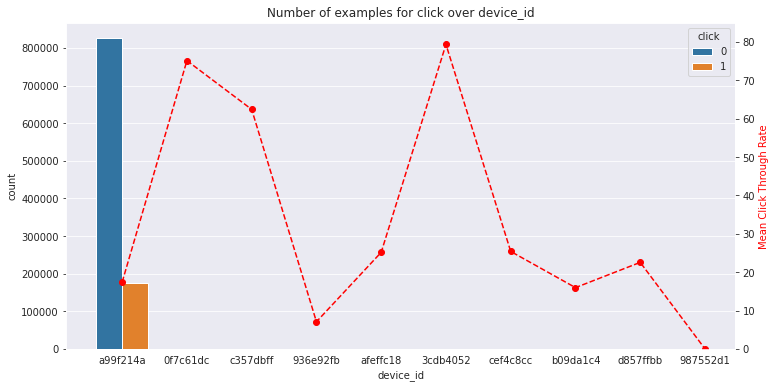

In [ ]:
categClassify(x='device_id', hue='click', data=df_train, value_stat="id", topN=10)

The CTR for the top 10 device_id have big fluctuations (0.00% ~ 77.02%).

##### **device_ip**

click         0     1    CTR  percentOfData
device_ip                                  
6b9769f2   4779  1372 22.305          0.005
431b3174   3363   792 19.061          0.003
af62faf4   2401   269 10.075          0.002
af9205f9   2380   270 10.189          0.002
2f323f36   2335   263 10.123          0.002
930ec31d   2317   261 10.124          0.002
009a7861   2323   247  9.611          0.002
d90a7774   2277   253 10.000          0.002
285aa37d   2274   252  9.976          0.002
6394f6f6   2182   208  8.703          0.002


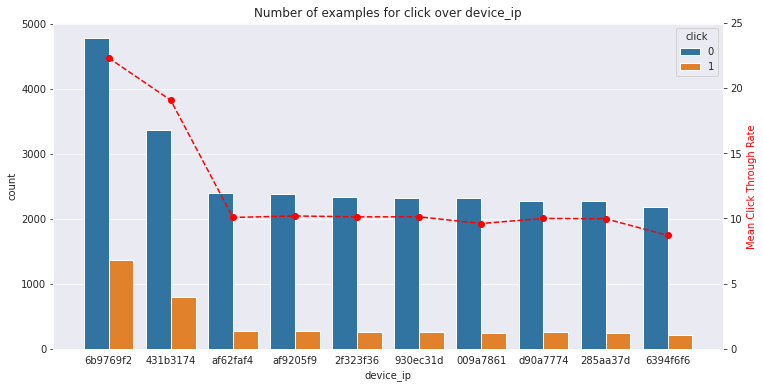

In [ ]:
categClassify(x='device_ip', hue='click', data=df_train, value_stat="id", topN=10)

##### **device_model**

click             0      1    CTR  percentOfData
device_model                                    
8a4875bd      63617  10149 13.758          0.061
1f0bc64f      33172   9712 22.647          0.035
d787e91b      32435   9201 22.099          0.034
76dc4769      18920   4393 18.844          0.019
be6db1d7      18068   4152 18.686          0.018
a0f5f879      16215   3257 16.727          0.016
4ea23a13      15195   4158 21.485          0.016
7abbbd5c      15673   3354 17.628          0.016
ecb851b2      14843   3325 18.301          0.015
d4897fef      12101   2524 17.258          0.012


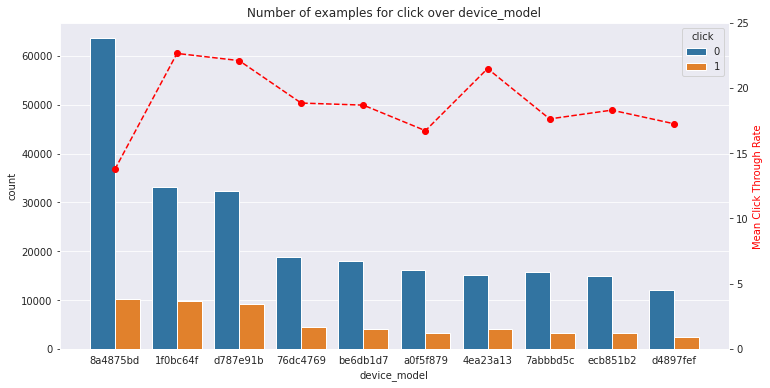

In [ ]:
categClassify(x='device_model', hue='click', data=df_train, value_stat="id", topN=10)

##### **device_type**

click             0       1    CTR  percentOfData
device_type                                      
0             52848   13754 20.651          0.055
1            928502  189482 16.949          0.923
2                 2       0  0.000          0.000
4             20839    2213  9.600          0.019
5              3428     371  9.766          0.003


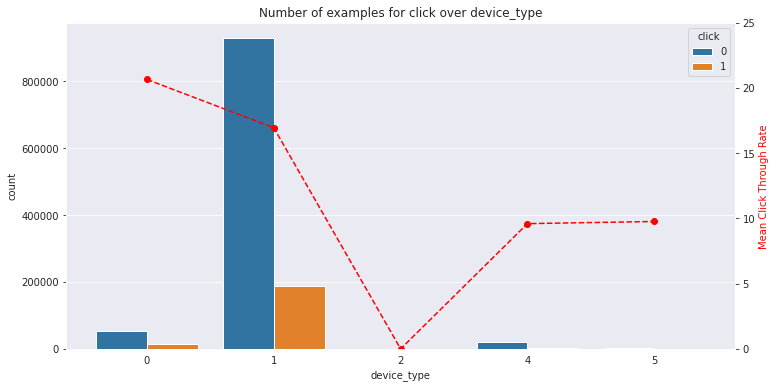

In [ ]:
categClassify(x='device_type', hue='click', data=df_train, value_stat="id")

Device_type 1 get the most impressions and clicks. 

##### **device_conn_type**

click                  0       1    CTR  percentOfData
device_conn_type                                      
0                 856014  189420 18.119          0.863
2                  85883   13559 13.635          0.082
3                  62496    2790  4.274          0.054
5                   1226      51  3.994          0.001


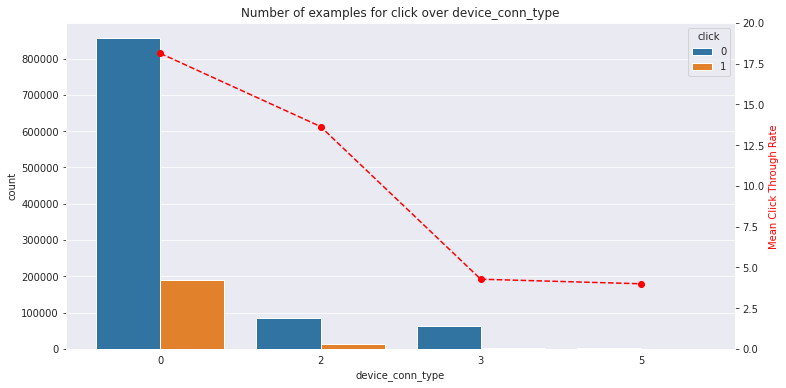

In [ ]:
categClassify(x='device_conn_type', hue='click', data=df_train, value_stat="id")

Device_conn_type 0 get the most impressions and clicks. 

#### **C1, C14 - C21 features**

In [ ]:
df_train[['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', \
          'C21']].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439,1211439
unique,7,2302,8,9,425,4,67,165,60
top,1005,4687,320,50,1722,0,35,-1,23
freq,1113140,28362,1129748,1142340,134643,506953,364411,566358,266332


##### **C1**

click       0       1    CTR  percentOfData
C1                                         
1001      256       8  3.030          0.000
1002    52848   13754 20.651          0.055
1005   924310  188830 16.964          0.919
1007      956      51  5.065          0.001
1008      128      26 16.883          0.000
1010    24267    2584  9.623          0.022
1012     2854     567 16.574          0.003


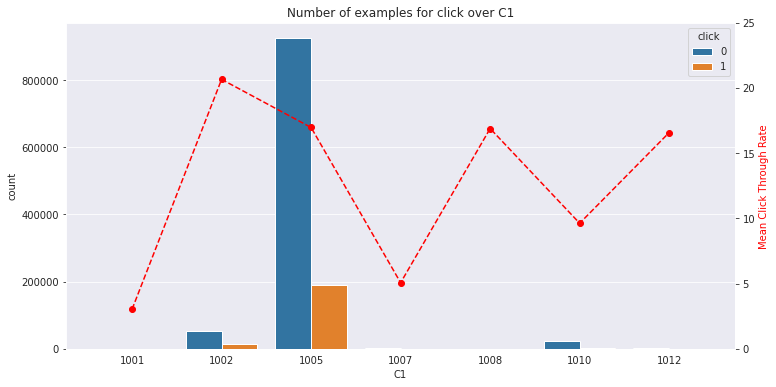

In [ ]:
categClassify(x='C1', hue='click', data=df_train, value_stat="id")

##### **C15**

click       0       1    CTR  percentOfData
C15                                        
120       101       1  0.980          0.000
216      7966    1162 12.730          0.008
300     44932   25141 35.878          0.058
320    950412  179336 15.874          0.933
480        41      24 36.923          0.000
728      2083     120  5.447          0.002
768        22      15 40.541          0.000
1024       62      21 25.301          0.000


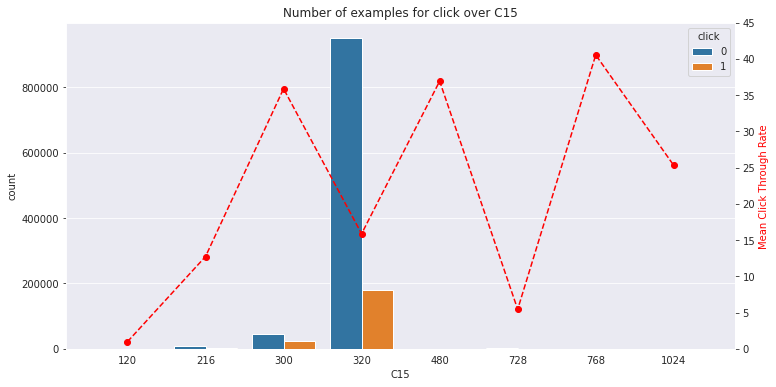

In [ ]:
categClassify(x='C15', hue='click', data=df_train, value_stat="id")

##### **C16**

click       0       1    CTR  percentOfData
C16                                        
20        101       1  0.980          0.000
36       7966    1162 12.730          0.008
50     961367  180973 15.842          0.943
90       2083     120  5.447          0.002
250     31510   22851 42.036          0.045
320        41      24 36.923          0.000
480      2467     653 20.929          0.003
768        62      21 25.301          0.000
1024       22      15 40.541          0.000


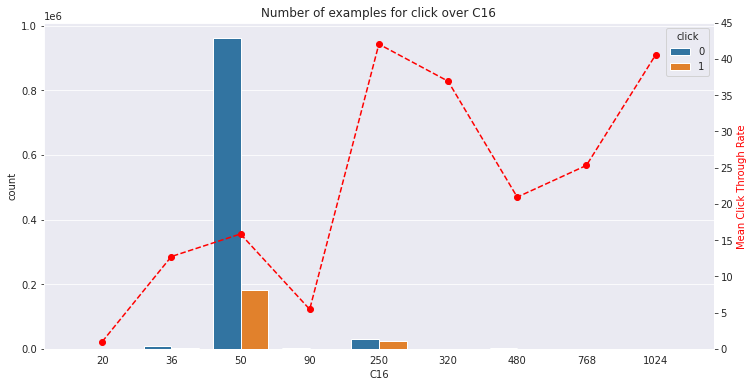

In [ ]:
categClassify(x='C16', hue='click', data=df_train, value_stat="id")

##### **C18**

click       0      1    CTR  percentOfData
C18                                       
0      426562  80391 15.858          0.418
1       78903   2852  3.488          0.067
2      149875  63070 29.618          0.176
3      350279  59507 14.521          0.338


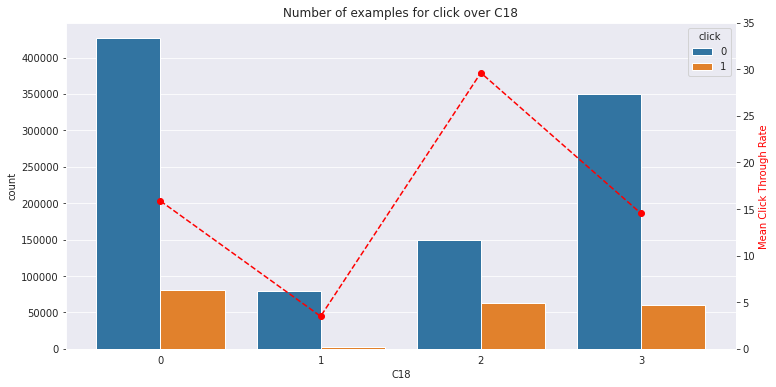

In [ ]:
categClassify(x='C18', hue='click', data=df_train, value_stat="id")

## 1.3 Data Preprocessing

### 1.3.1 Target Encoder

In [ ]:
class TargetEncoder(object):
  def __init__(self):
    self.map = None
    self.prior = None

  def fit(self, X_train, y_train, minN=30):
    self.map = {}
    self.prior = y_train.mean()
    for col in X_train.columns:
      tmp = y_train.groupby(X_train[col]).agg(['sum', 'count']).reset_index()
      N_prior = np.maximum(minN - tmp['count'], 0)
      tmp['sum'] += N_prior * self.prior
      tmp['count'] += N_prior
      tmp[col + '_te'] = tmp['sum'] / tmp['count']
      self.map[col] = tmp[[col, col + '_te']]
  
  def transform(self, X):
    cols = X.columns
    X['idx'] = np.arange(X.shape[0])
    X_res = pd.DataFrame()
    for col in cols:
      if col in self.map:
        tmp = pd.merge(X[['idx', col]], self.map[col], on=col, how='left')
        tmp.fillna(self.prior, inplace=True)
        tmp.sort_values(by='idx', inplace=True)
        X_res[col] = tmp[col + '_te']
      else:
        X_res[col] = X[col]
    #X.drop('idx', inplace=True)
    return X_res

### 1.3.2 One-hot Encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

### 1.3.3 Label Encoder

In [ ]:
class LabelEncoder(object):
  def __init__(self):
    self.cate_feat_szs = []
  
  def fit(self, X0, p0=0.99):
    self.cate_feat_map = []
    for col in X0.columns:
      amap = {}
      tmp = X0[col].value_counts(normalize=True).reset_index()
      #print(tmp)
      pp = 0.0
      i = 0
      while pp < p0 and i < tmp.shape[0]:
        amap[tmp.iloc[i]['index']] = i
        pp += tmp.iloc[i][col]
        i += 1
      self.cate_feat_map.append(amap)
      self.cate_feat_szs.append(i + 1)
  
  def transform(self, X0):
    X = X0.copy()
    for i in range(X.shape[1]):
      col = X.columns[i]
      num = self.cate_feat_szs[i] - 1
      map = self.cate_feat_map[i]
      X[col] = X[col].map(lambda s: map[s] if s in map else num)
    return X

if 1 == 2:
  le = LabelEncoder()
  x = pd.DataFrame({'a':['a', 'b', 'c', 'a', 'b', 'b','a','c','e','f','h'],
                  'b':['g', 'h', 'm', 's', 'g', 'h','a', 'b', 'c', 'a', 'b']})
  le.fit(x, p0=0.85)
  print(x)
  print(le.cate_feat_szs)
  print(le.cate_feat_map)
  print(le.transform(x))

### 1.3.4 Training and testing splitting

In [ ]:
from sklearn.model_selection import train_test_split

y_train = df_train['click']
X_train0 = df_train.drop(['id', 'click', 'day_hour', 'date'], axis=1)

X_train0, X_test0, y_train, y_test = train_test_split(X_train0, y_train, 
    train_size=0.8, stratify=y_train, random_state=42)

In [ ]:
cols_onehot = []
cols_target = []
minNuniq = 10
for col in X_train0.columns:
  if X_train0[col].nunique() > minNuniq:
    cols_target.append(col)
  else:
    cols_onehot.append(col)
#print(cols_onehot)
#print(cols_target)
#print(X_train0[cols_onehot].nunique())
#print(X_train0[cols_target].nunique())

# **Part 2: Models**

## 2.1 Logistic Regression (base model)

In [ ]:
te = TargetEncoder()
te.fit(X_train0[cols_target], y_train)
X_train = te.transform(X_train0[cols_target])
X_test = te.transform(X_test0[cols_target])

ohe.fit(X_train0[cols_onehot])
out = pd.DataFrame(ohe.transform(X_train0[cols_onehot]),\
                   columns=ohe.get_feature_names(cols_onehot))
X_train = pd.concat([X_train, out], axis=1)

out = pd.DataFrame(ohe.transform(X_test0[cols_onehot]),\
                   columns=ohe.get_feature_names(cols_onehot))
X_test = pd.concat([X_test, out], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 2.1.1 Model parameters

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# F1 score used as a performance metric
n_fold = 5
skfold = StratifiedKFold(n_splits=n_fold, random_state=42)

n_c = 5
c_values = np.logspace(-1, 3, n_c)
aucs = np.zeros((n_fold, n_c))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### 2.1.2 Train Model

In [ ]:
i = 0
for train_idx, valid_idx in skfold.split(X_train, y_train):
    for j, c in enumerate(c_values):
        lr = LogisticRegression(penalty='l2', C = c, max_iter=2000,
                                random_state=42, solver='saga')
        lr.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])

        #validation_Set evaluation
        y_prob = lr.predict_proba(X_train.iloc[valid_idx])[:, 1]
        aucs[i][j] = roc_auc_score(y_train.iloc[valid_idx], y_prob)
        print(i, j, aucs[i][j])
    i += 1

0 0 0.8593313527500268
0 1 0.8749303374982598
0 2 0.8782163162285714
0 3 0.8785919516265113
0 4 0.8786260326498552
1 0 0.8593196793167414
1 1 0.8754362256834677
1 2 0.8788229056817289
1 3 0.8792205110734389
1 4 0.8792615170819094
2 0 0.85673038361493
2 1 0.8727875000224424
2 2 0.8762206962947215
2 3 0.8766257814475049
2 4 0.8766671471760149
3 0 0.8590731935215041
3 1 0.8745872082558586
3 2 0.8778314810166103
3 3 0.8782154293142914
3 4 0.8782548331908544
4 0 0.8571640717953042
4 1 0.8730262567438191
4 2 0.8764412376123871
4 3 0.8768455300977173
4 4 0.8768866822778407


In [ ]:
aucs.mean(axis=0)

array([0.85832374, 0.87415351, 0.87750653, 0.87789984, 0.87793924])

### 2.1.3 Model selection based on performance

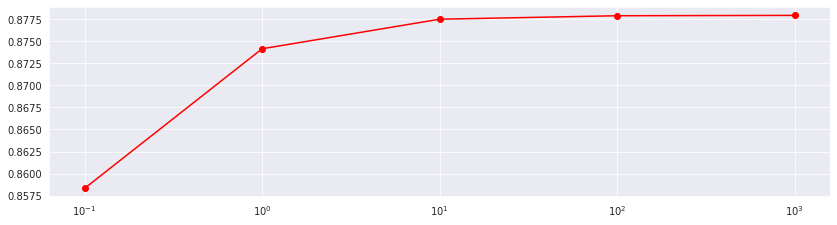

In [ ]:
plt.figure(figsize=(14, 3.5))
plt.plot(c_values, aucs.mean(axis=0), 'r-o')
plt.xscale('log')

### 2.1.4 Model performance over testing data

In [ ]:
lr = LogisticRegression(penalty='l2', C = c_values[3], max_iter=2000,
                        random_state=42, solver='saga')
lr.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_lr = lr.predict(X_test)

print('Confusion Matrix:\n', '='*40)
confM = pd.DataFrame({'pred': y_lr, 'actual': y_test})
confM = confM.groupby('pred')['actual'].agg([lambda x: x.size-x.sum(), 'sum'])
confM.columns = ['actual_0', 'actual_1']
print(confM)

print('\nClassification Report\n', '='*40)
print(classification_report(y_test, y_lr))

Confusion Matrix:
      actual_0  actual_1
pred                    
0       193921     36770
1         7203      4394

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.90    201124
           1       0.38      0.11      0.17     41164

    accuracy                           0.82    242288
   macro avg       0.61      0.54      0.53    242288
weighted avg       0.76      0.82      0.77    242288



ROC curve

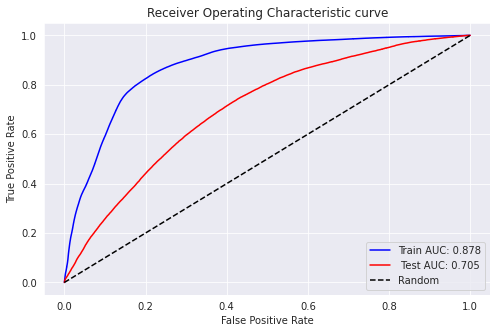

In [ ]:
assert lr.classes_[1] == 1 # confirm the second column is "1" class

fig = plt.figure(figsize=[8, 5])

p_pred = lr.predict_proba(X_train)[:, 1]
fpr, tpr, thresh = roc_curve(y_train, p_pred)
auc = roc_auc_score(y_train, p_pred)
plt.plot(fpr, tpr, 'b-', label=f'Train AUC: {auc:.3f}')

p_pred = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, p_pred)
auc = roc_auc_score(y_test, p_pred)
plt.plot(fpr, tpr, 'r-', label=f' Test AUC: {auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()

## 2.2: XGBoost Model

In [ ]:
import xgboost as xgb

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

### 2.2.1 Bayesian Optimization

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=bb77b41754423804376da5b13cc02ad5803239c28a1ca4b10eb6f232962eae6d
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


### 2.2.2 Hyper-parameter Optimization

In [ ]:
def obj_func(n_estimators, max_depth, min_child_weight, eta, colsample_bytree, subsample, gamma, lmbd):
  params = {"n_estimators": int(round(n_estimators)),
            "max_depth": int(round(max_depth)),
            "min_child_weight": min_child_weight,
            "eta": eta,
            "colsample_bytree": colsample_bytree,
            "subsample": subsample,
            "gamma": gamma,
            "lambda": lmbd,
            "obj": "binary:logistic",
            "eval_metric": "logloss"}
  #Cross validating with the specified parameters in 5 folds and 100 iterations
  cv_hist = xgb.cv(params, D_train, nfold=5)
  return -cv_hist['test-logloss-mean'].iloc[-1]

optimizer = BayesianOptimization(obj_func,
                                 pbounds={"n_estimators": [50, 100],
                                          "max_depth": [3, 15],
                                          "min_child_weight": [5, 10],
                                          "eta": [0.01, 0.30],
                                          "colsample_bytree": [0.2, 0.9],
                                          "subsample": [0.2, 0.9],
                                          "gamma": [0.0, 0.4],
                                          "lmbd": [0.2, 0.8]},
                                 verbose=2,
                                 random_state=42)

optimizer.maximize(init_points=15, n_iter=10,)
print(optimizer.max)

|   iter    |  target   | colsam... |    eta    |   gamma   |   lmbd    | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2007   |  0.4622   |  0.2857   |  0.2928   |  0.5592   |  4.872    |  5.78     |  52.9     |  0.8063   |
|  2        | -0.2027   |  0.6208   |  0.2153   |  0.008234 |  0.7819   |  12.99    |  6.062    |  59.09    |  0.3284   |
|  3        | -0.2766   |  0.413    |  0.1622   |  0.1728   |  0.3747   |  10.34    |  5.697    |  64.61    |  0.4565   |
|  4        | -0.1966   |  0.5192   |  0.2377   |  0.07987  |  0.5085   |  10.11    |  5.232    |  80.38    |  0.3194   |
|  5        | -0.2482   |  0.2455   |  0.2852   |  0.3863   |  0.685    |  6.655    |  5.488    |  84.21    |  0.5081   |
|  6        | -0.3286   |  0.2854   |  0.1536   |  0.01376  |  0.7456   |  6.105    |  8.313    |  65.59    |  0.564    |
|  7        | -0.4098   

### 2.2.3 Train model

In [ ]:
from xgboost import XGBClassifier

params = optimizer.max['params']
params['lambda'] = params['lmbd']
del params['lmbd']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))

xgb_clf = XGBClassifier(objective="binary:logistic", eval_metric="logloss", **params)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.3,
              eval_metric='logloss', gamma=0.4, lambda=0.2, learning_rate=0.1,
              max_delta_step=0, max_depth=15, min_child_weight=5.0,
              missing=None, n_estimators=86, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9, verbosity=1)

### 2.2.4 Model performance over testing data

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

y_xgb = xgb_clf.predict(X_test)

print('Confusion Matrix:\n', '='*40)
confM = pd.DataFrame({'pred': y_xgb, 'actual': y_test})
confM = confM.groupby('pred')['actual'].agg([lambda x: x.size-x.sum(), 'sum'])
confM.columns = ['actual_0', 'actual_1']
print(confM)

print('\nClassification Report\n', '='*40)
print(classification_report(y_test, y_xgb))

Confusion Matrix:
      actual_0  actual_1
pred                    
0       192224     35183
1         8900      5981

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90    201124
           1       0.40      0.15      0.21     41164

    accuracy                           0.82    242288
   macro avg       0.62      0.55      0.56    242288
weighted avg       0.77      0.82      0.78    242288



ROC curve

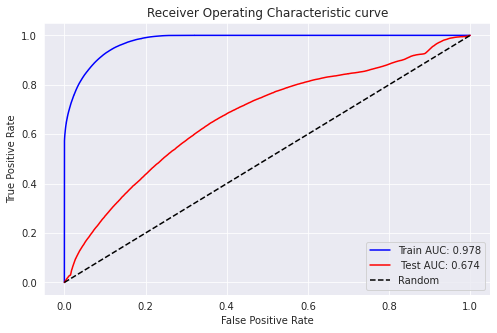

In [ ]:
assert xgb_clf.classes_[1] == 1 # confirm the second column is "1" class

fig = plt.figure(figsize=[8, 5])

p_pred = xgb_clf.predict_proba(X_train)[:, 1]
fpr, tpr, thresh = roc_curve(y_train, p_pred)
auc = roc_auc_score(y_train, p_pred)
plt.plot(fpr, tpr, 'b-', label=f'Train AUC: {auc:.3f}')

p_pred = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, p_pred)
auc = roc_auc_score(y_test, p_pred)
plt.plot(fpr, tpr, 'r-', label=f' Test AUC: {auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()

### 2.2.5 Feature importance

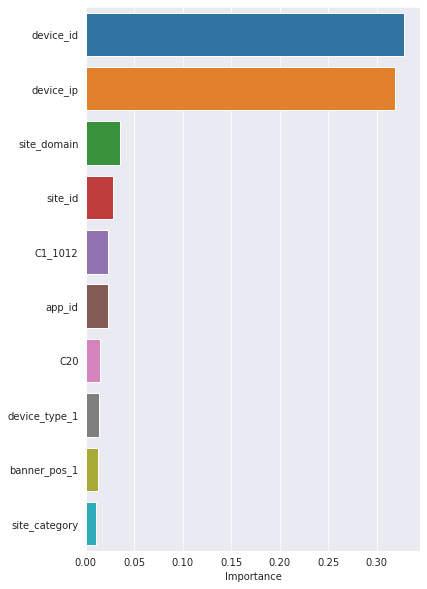

In [ ]:
feat_im = pd.DataFrame({'feat_nm': X_train.columns,
                        'Importance': xgb_clf.feature_importances_})
feat_im.sort_values(by='Importance', ascending=False, inplace=True)

fig = plt.figure(figsize=[6, 10])
sns.barplot(x='Importance', y='feat_nm', data=feat_im[:10])
plt.ylabel("")
plt.show()

## 2.3 DeepFM model

### 2.3.0 Import necessary package

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from time import time

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda:0


### 2.3.1 MyDataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, X_data, y_data):
    super(MyDataset, self).__init__()
    self.X = torch.from_numpy(X_data.astype(np.int64).values)
    self.y = torch.from_numpy(y_data.astype(np.float32).values)
  
  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

In [ ]:
le = LabelEncoder()
le.fit(X_train0)
X_train = le.transform(X_train0)
X_test = le.transform(X_test0)
train_data = MyDataset(X_train, y_train)
test_data = MyDataset(X_test, y_test)

### 2.3.2 DeepFM model

![a](https://drive.google.com/uc?export=view&id=1yzLoZW8msjJhYgHCeWXlGP6zF4giPkOC)

In [ ]:
class DeepFM(nn.Module):
  """
  DeepFM = Deep (high-order interaction) + FM (low-order interaction)
  """
  def __init__(self, 
               cate_feat_szs, 
               embed_sz=20,
               hidden_dims=[128, 64, 32], 
               dropout=[0.5, 0.5, 0.5]):
    super(DeepFM, self).__init__()
    
    # Shared embedding
    self.fm_1_embed = nn.ModuleList([nn.Embedding(feat_sz, 1) \
        for feat_sz in cate_feat_szs])
    self.fm_2_embed = nn.ModuleList([nn.Embedding(feat_sz, embed_sz) \
        for feat_sz in cate_feat_szs])
    
    # Deep component
    self.mlp_dim = len(cate_feat_szs) * embed_sz
    pre_dim = self.mlp_dim
    self.mlp = nn.ModuleList()
    self.bn = nn.ModuleList()
    self.dropout = nn.ModuleList()
    for i in range(len(hidden_dims)):
      dim = hidden_dims[i]
      self.mlp.append(nn.Linear(pre_dim, dim))
      nn.init.kaiming_normal_(self.mlp[-1].weight.data)
      self.bn.append(nn.BatchNorm1d(dim))
      self.dropout.append(nn.Dropout(dropout[i]))
      pre_dim = dim
    self.out = nn.Linear(pre_dim, 1)

  def forward(self, X):
    """
    X: sparse_feature [batch_size, sparse_feature_size]
    """
    # FM component (1 order)
    X1 = [embed(X[:, i].unsqueeze(1)) for i, embed in enumerate(self.fm_1_embed)]
    X1 = torch.cat(X1, dim=1) # [batch_sz, field_sz, 1]
    X1 = torch.sum(X1, dim=1) # [batch_sz, 1]
    # FM component (2 order)
    X2 = [embed(X[:, i].unsqueeze(1)) for i, embed in enumerate(self.fm_2_embed)]
    X2 = torch.cat(X2, dim=1) # [batch_sz, field_sz, embed_sz]
    # xy = [(x+y)^2 - x^2 - y^2]/2
    # (x+y)^2
    X2_sum = torch.sum(X2, dim=1) # [batch_sz, embed_sz]
    X2_sum = X2_sum * X2_sum
    # x^2 + y^2
    X2_squ = X2 * X2 # [batch_sz, field_sz, embed_sz]
    X2_squ = torch.sum(X2_squ, dim=1) # [batch_sz, embed_sz]
    # xy
    XY = (X2_sum - X2_squ) * 0.5 # [batch_sz, embed_sz]
    XY = torch.sum(XY, dim=1, keepdim=True) # [batch_sz, 1]

    # DNN component
    X_emb = X2.view(X2.shape[0], self.mlp_dim) # [batch_sz, field_sz * embed_sz]
    for i in range(len(self.mlp)):
      X_emb = self.dropout[i](F.relu(self.mlp[i](X_emb)))
      X_emb = self.bn[i](X_emb)
    X_emb = self.out(X_emb)
    X_emb = X1 + XY + X_emb
    prob = torch.sigmoid(X_emb).squeeze()
    return prob

# testing
if 1 == 2:
  deepFM = DeepFM([2,3], 3, [3, 2])
  for nm, param in deepFM.named_parameters():
    print(nm, param)

### 2.3.3 Model Training

In [ ]:
def model_train(train_data, test_data, le=le, epoches=15, batch_sz=128):
  train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_sz, shuffle=True)
  
  model = DeepFM(le.cate_feat_szs).to(device)
  criterion = nn.BCELoss(reduction='sum')
  optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)

  print_every = 1000
  history = [] # [epoch, train_bceloss, test_bceloss]
  
  model.train()
  for epoch in range(1, epoches + 1):
    t0 = time()
    loss = 0
    data_sz = 0
    for i, (X, y) in enumerate(train_loader, 0):
      X = X.to(device)
      y = y.to(device)
      prob = model.forward(X)
      batch_loss = criterion(prob, y)

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

      loss += batch_loss.item()
      data_sz += X.shape[0]

      if (i+1) % print_every == 0:
        dt = time() - t0
        print(f'Epoch {epoch:2d}: {data_sz} rows - {dt:.3f}s - BCELoss {loss / data_sz:.3f}')
    train_bceloss = loss / data_sz
    
    model.eval()
    loss = 0
    data_sz = 0
    for i, (X, y) in enumerate(test_loader, 0):
      X = X.to(device)
      y = y.to(device)
      prob = model.forward(X)
      loss += criterion(prob, y).item()
      data_sz += X.shape[0]
    test_bceloss = loss / data_sz
    history.append([epoch, train_bceloss, test_bceloss])
    model.train()

  return model, history

### 2.3.4 Training result

Epoch  1: 128000 rows - 10.613s - BCELoss 15.182
Epoch  1: 256000 rows - 21.146s - BCELoss 14.206
Epoch  1: 384000 rows - 31.831s - BCELoss 13.222
Epoch  1: 512000 rows - 42.468s - BCELoss 12.220
Epoch  1: 640000 rows - 53.114s - BCELoss 11.256
Epoch  1: 768000 rows - 63.702s - BCELoss 10.388
Epoch  1: 896000 rows - 74.292s - BCELoss 9.604
Epoch  2: 128000 rows - 10.653s - BCELoss 3.085
Epoch  2: 256000 rows - 21.283s - BCELoss 2.799
Epoch  2: 384000 rows - 31.983s - BCELoss 2.529
Epoch  2: 512000 rows - 42.588s - BCELoss 2.306
Epoch  2: 640000 rows - 53.242s - BCELoss 2.112
Epoch  2: 768000 rows - 63.820s - BCELoss 1.960
Epoch  2: 896000 rows - 74.431s - BCELoss 1.822
Epoch  3: 128000 rows - 10.678s - BCELoss 0.561
Epoch  3: 256000 rows - 21.357s - BCELoss 0.547
Epoch  3: 384000 rows - 32.019s - BCELoss 0.534
Epoch  3: 512000 rows - 42.645s - BCELoss 0.525
Epoch  3: 640000 rows - 53.228s - BCELoss 0.518
Epoch  3: 768000 rows - 63.814s - BCELoss 0.516
Epoch  3: 896000 rows - 74.404s - 

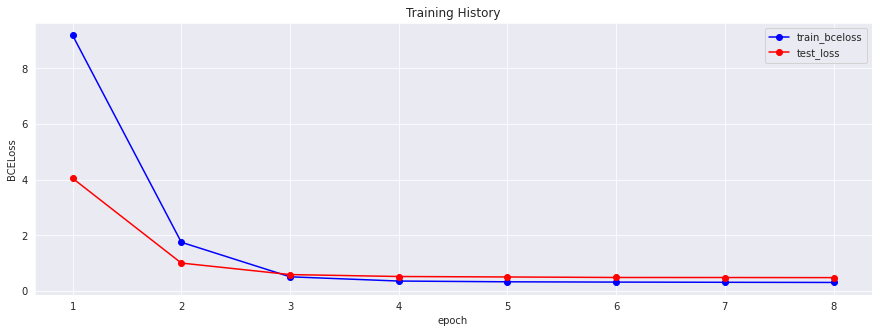

In [ ]:
model, history = model_train(train_data, test_data, epoches=8)

history = pd.DataFrame(history, columns=['epoch', 'train_bceloss', 'test_bceloss'])
fig = plt.figure(figsize=(15, 5))
plt.plot(history.epoch, history.train_bceloss, 'b-o', label='train_bceloss')
plt.plot(history.epoch, history.test_bceloss, 'r-o', label='test_loss')
plt.xlabel("epoch")
plt.ylabel("BCELoss")
plt.title("Training History")
plt.legend(loc="upper right")
plt.show()

In [ ]:
history

,epoch,train_bceloss,test_bceloss
0,1,9.185,4.050
1,2,1.753,1.005
2,3,0.511,0.591
3,4,0.359,0.522
4,5,0.332,0.505
5,6,0.321,0.487
6,7,0.314,0.485
7,8,0.308,0.481


In [ ]:
def model_pred(model, train_data, batch_sz=32):
  train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True)
  prob = []
  labl = []
  model.eval()
  for i, (X, y) in enumerate(train_loader, 0):
    X = X.to(device)
    yp = model.forward(X)
    prob += yp.cpu().detach().numpy().tolist()
    labl += y.numpy().astype(np.int32).tolist()
  return prob, labl

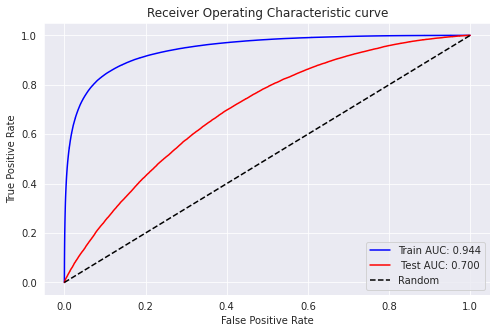

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
fig = plt.figure(figsize=[8, 5])

prob, labl = model_pred(model, train_data)
fpr, tpr, thresh = roc_curve(labl, prob)
auc = roc_auc_score(labl, prob)
plt.plot(fpr, tpr, 'b-', label=f'Train AUC: {auc:.3f}')

prob, labl = model_pred(model, test_data)
fpr, tpr, thresh = roc_curve(labl, prob)
auc = roc_auc_score(labl, prob)
plt.plot(fpr, tpr, 'r-', label=f' Test AUC: {auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()